**Question: Is alignment needed, or are cell types easily identified in differnet modalities:**
 - Get uncoupled representation
 - Obtain 33 types from reference taxonomy
 - Train QDA classifiers for on T
 - Train QDA classifiers for on E
 - Plot consensus matrix

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from pathlib import Path
from refactor.utils.tree_helpers import get_merged_ordered_classes
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.model_selection import StratifiedKFold
from refactor.utils.compute import contingency,contingency_metric
from refactor.utils.plots import matrix_scatterplot

sns.set()
sns.set_style('ticks',{'axes.grid' : False})
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
representation_cc_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = Path('./refactor/data/proc/PS_v5_beta_0-4_pc_scaled_ipfx_eqTE.mat')
E_names_file = Path('./refactor/data/proc/E_names.json')
figure_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

O = sio.loadmat(origdata_pth,squeeze_me=True)
O['E_dat']=np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
O['E_names']=np.concatenate([O['pc_name'],O['feature_name']],axis = 0)
with open(E_names_file) as f:
    temp = json.load(f)
O['E_names'] = np.array([temp[i] for i in O['E_names']])

#Get t-types in order as per reference taxonomy:
O = sio.loadmat(origdata_pth,squeeze_me=True)
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=n_required_classes)

#well-sampled t-types:
min_sample_thr=10
t_types_well_sampled = []
for t in t_types:
    if np.sum(O['cluster']==t)>min_sample_thr:
        t_types_well_sampled.append(t)
        
        
#Obtain 33 types by merging the reference taxonomy:----------------
ref_tax_33,ref_tax_33_order = get_merged_ordered_classes(np.array(t_types_well_sampled).copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=33)

ref_tax_33_order_renamed = np.array(ref_tax_33_order.copy())
ref_tax_33_order_renamed[ref_tax_33_order_renamed=='n81'] = 'Lamp5 Fam19a1 Tmem182'
ref_tax_33_order_renamed[ref_tax_33_order_renamed=='n75'] = 'Vip Lect1 Oxtr'
ref_tax_33_order_renamed = ref_tax_33_order_renamed.tolist()

#Same experiment with full reference hierarchy:----------------------
# ref_tax_33,ref_tax_33_order = get_merged_ordered_classes(np.array(t_types_well_sampled).copy(),
#                                                    htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
#                                                    n_required_classes=np.unique(O['cluster'].size))

# ref_tax_33_order_renamed = np.array(ref_tax_33_order.copy())
# ref_tax_33_order_renamed[ref_tax_33_order_renamed=='n81'] = 'Lamp5 Fam19a1 Tmem182'
# ref_tax_33_order_renamed[ref_tax_33_order_renamed=='n75'] = 'Vip Lect1 Oxtr'
# ref_tax_33_order_renamed = ref_tax_33_order_renamed.tolist()



#Get 33 type labels for individual samples
gt_labels = O['cluster'].copy()
for (orig,updated) in zip(t_types_well_sampled,ref_tax_33):
    gt_labels[gt_labels==orig]=updated
    
keep = np.isin(gt_labels,ref_tax_33)
keep_ind = np.flatnonzero(keep)

Performed 0 merges. Remaining classes in data = 59
Performed 22 merges. Remaining classes in data = 33


In [ ]:
#fname = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/33_class_well_sampled_tasic.mat'
#sio.savemat(fname,{'keep_ind':keep_ind,'gt_labels':gt_labels,'ref_tax_33_order':ref_tax_33_order})

#### Get uncoupled representations from among the 43-fold experiments

In [3]:
alpha_T=1.0
alpha_E=1.0
lambda_TE=0.0
aug = 0
n_cvfolds = 21

#gt_labels=gt_labels[keep_ind]
CVdict={}
key_list = ['XrT','XrE','zE','zT']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname=(f'NM_Edat_pcipfx_aT_{alpha_T:0.1f}_aE_{alpha_E:0.1f}_cs_{lambda_TE:0.1f}'+\
              f'_ad_{aug:d}_ld_3_bs_200_se_500_ne_1500_cv_{cv:d}_ri_0_500_ft-summary').replace('.','-') + '.mat'

    if Path(representation_pth+cvfold_fname).is_file(): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X       
    else:
        print(cvfold_fname,'not found')
        
XE = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
XE[np.isnan(XE)]=0


XT = O['T_dat'].copy()
#XE = XE[keep_ind,:]
#XT = XT[keep_ind,:]

100%|██████████| 21/21 [00:04<00:00,  4.59it/s]


- Representations have no knowledge of clusters. We can define the train and test set we like.
- We use the same train/test split used for the de novo clustering experiments
- CVfolds ~ Initializations for the uncoupled representations

In [4]:
#skf = StratifiedKFold(n_splits=6, random_state=0, shuffle=True)
#ind_dict = [{'train':train_ind, 'val':val_ind} for train_ind, val_ind in skf.split(X=np.zeros(shape=gt_labels.shape), y=gt_labels)]

ref_path = '/home/rohan/Remote-AI/dat/result/TE_NM_cc/'
reference_fold = sio.loadmat(ref_path+'NM_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_cv_0_ri_0_500_ft-summary.mat',squeeze_me=True)
ind_dict = {'train':reference_fold['train_ind'],'test':reference_fold['test_ind']}
ind_dict['train'] = ind_dict['train'][np.isin(ind_dict['train'],keep_ind)]
ind_dict['test'] = ind_dict['test'][np.isin(ind_dict['test'],keep_ind)]

In [5]:
cv_mse_list=[]
for cv in tqdm(range(n_cvfolds)):
    test_ind = ind_dict['test']
    cv_mse = np.mean((CVdict[cv]['XrT'][test_ind,:]-XT[test_ind,:])**2) + \
             np.mean((CVdict[cv]['XrE'][test_ind,:]-XE[test_ind,:])**2)
    cv_mse_list.append(cv_mse)    
    
best_model_ind = np.argsort(cv_mse_list)
best_model_ind = best_model_ind[:5]
print(best_model_ind)

100%|██████████| 21/21 [00:00<00:00, 98.00it/s]

[14  8 20  9  7]


In [7]:
f_consistency_list=[]
f_confidence_list=[]
for cv in best_model_ind:
    qda = QDA(reg_param=1e-2,store_covariance=True)
    train_ind = ind_dict['train']
    test_ind = ind_dict['test']
    all_ind = np.concatenate([ind_dict['train'],ind_dict['test']])
    
    qda.fit(CVdict[cv]['zE'][train_ind],gt_labels[train_ind])
    lbl_pred_E = qda.predict(CVdict[cv]['zE'])

    qda.fit(CVdict[cv]['zT'][train_ind],gt_labels[train_ind])
    lbl_pred_T = qda.predict(CVdict[cv]['zT'])
    
    C_test = contingency(a=lbl_pred_E[test_ind],
                    b=lbl_pred_T[test_ind],
                    unique_a=ref_tax_33_order,
                    unique_b=ref_tax_33_order)
    
    C_all = contingency(a=lbl_pred_E[all_ind],
                b=lbl_pred_T[all_ind],
                unique_a=ref_tax_33_order,
                unique_b=ref_tax_33_order)

### Consensus based on supervised classification with uncoupled autoencoder representations

In [8]:
np.unique(gt_labels[ind_dict['train']]).shape

(33,)

In [9]:
np.unique(gt_labels[ind_dict['test']]).shape

(33,)

/home/rohan/Dropbox/AllenInstitute/CellTypes/code/Patchseq-AE-Bioarxiv/refactor/utils/compute.py:93: RuntimeWarning: invalid value encountered in true_divide
  row_consistency.append(X[ii,ii]/np.sum(X,axis=1))
/home/rohan/Dropbox/AllenInstitute/CellTypes/code/Patchseq-AE-Bioarxiv/refactor/utils/compute.py:94: RuntimeWarning: invalid value encountered in true_divide
  col_consistency.append(X[ii,ii]/np.sum(X,axis=0))
/home/rohan/Dropbox/AllenInstitute/CellTypes/code/Patchseq-AE-Bioarxiv/refactor/utils/compute.py:93: RuntimeWarning: divide by zero encountered in true_divide
  row_consistency.append(X[ii,ii]/np.sum(X,axis=1))
/home/rohan/Dropbox/AllenInstitute/CellTypes/code/Patchseq-AE-Bioarxiv/refactor/utils/compute.py:94: RuntimeWarning: divide by zero encountered in true_divide
  col_consistency.append(X[ii,ii]/np.sum(X,axis=0))


Total samples: 677
reliable row frac: 0.394
reliable col frac: 0.242
reliable cluster frac: 0.242
n(unreliable clusters): 25
f_consistency: 0.443
f_occupancy: 0.394


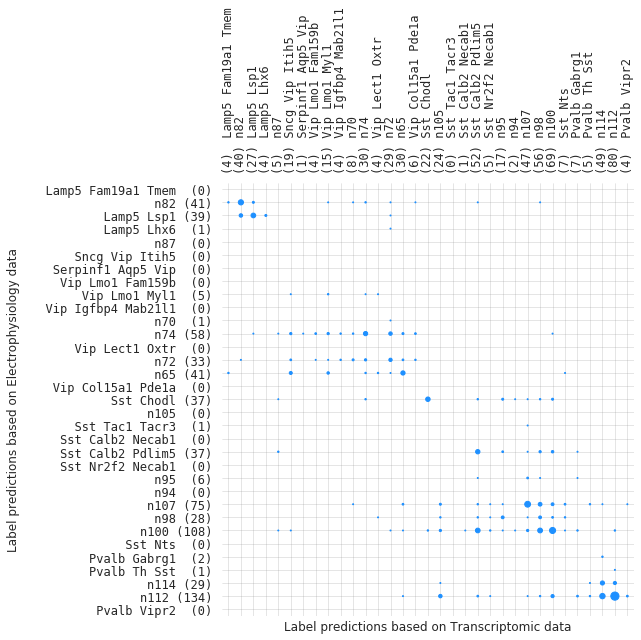


Total samples: 3386
reliable row frac: 0.424
reliable col frac: 0.273
reliable cluster frac: 0.273
n(unreliable clusters): 24
f_consistency: 0.448
f_occupancy: 0.485


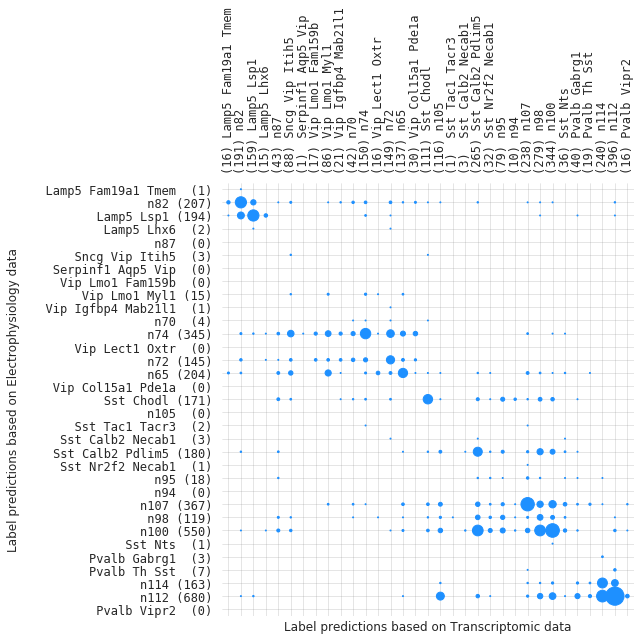

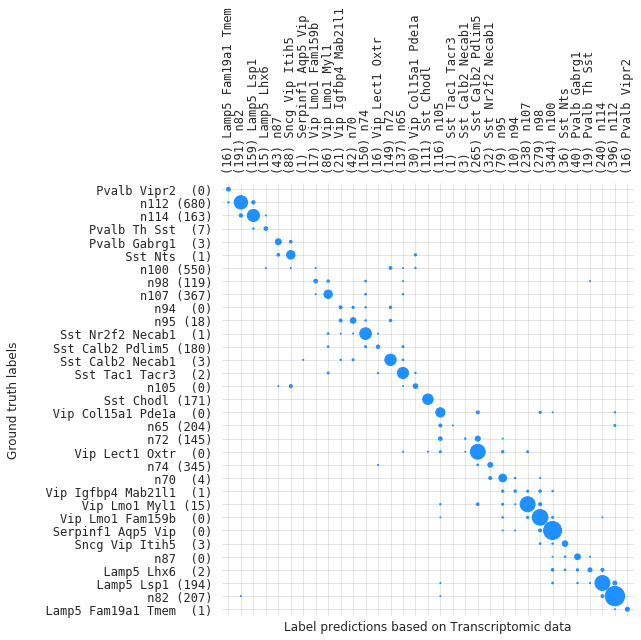

NameError: name 'ami' is not defined

In [10]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score
from refactor.utils.compute import contingency_metric, contingency

cv = 0

for fold in [best_model_ind[0]]:
    qda = QDA(reg_param=1e-2,store_covariance=True)
    train_ind = ind_dict['train']
    test_ind = ind_dict['test']
    all_ind = np.concatenate([ind_dict['train'],ind_dict['test']])
    
    qda.fit(CVdict[cv]['zE'][train_ind],gt_labels[train_ind])
    lbl_pred_E = qda.predict(CVdict[cv]['zE'])

    qda.fit(CVdict[cv]['zT'][train_ind],gt_labels[train_ind])
    lbl_pred_T = qda.predict(CVdict[cv]['zT'])
    
    
    #test_labels------------Consensus between E and T supervised classification labels----------
    C_test = contingency(a=lbl_pred_E[test_ind],
                    b=lbl_pred_T[test_ind],
                    unique_a=ref_tax_33_order,
                    unique_b=ref_tax_33_order)
    
    yname = ref_tax_33_order_renamed.copy()
    ydata = [f'({np.sum(lbl_pred_E[test_ind]==n):d})' for n in ref_tax_33_order]
    ylabelc = [f'{a:>20s} '+f'{b:>4s}' for (a,b) in zip(yname,ydata)]
    
    xname = ref_tax_33_order_renamed.copy()
    xdata = [f'({np.sum(lbl_pred_T[test_ind]==n):d})' for n in ref_tax_33_order]
    xlabelc = [f'{b:<4s}'+ f' {a:s}' for (a,b) in zip(xname,xdata)]

    matrix_scatterplot(C_test.copy(),
                       xticklabels=xlabelc,
                       yticklabels=ylabelc,
                       xlabel='Label predictions based on Transcriptomic data', ylabel='Label predictions based on Electrophysiology data',
                       mc = 'dodgerblue',
                       fig_width=9, 
                       fig_height=9, 
                       scale_factor=1.0)

    _ = contingency_metric(C_test.copy())
    plt.savefig(figure_path+'TE-supervised-consensus-all.png',dpi=300)
    plt.show()
    
    #all_labels------------Consensus between E and T supervised classification labels----------
    C_all = contingency(a=lbl_pred_E[all_ind],
                b=lbl_pred_T[all_ind],
                unique_a=ref_tax_33_order,
                unique_b=ref_tax_33_order)
    
    print()
        
    yname = ref_tax_33_order_renamed.copy()
    ydata = [f'({np.sum(lbl_pred_E[all_ind]==n):d})' for n in ref_tax_33_order]
    ylabelc = [f'{a:>20s} '+f'{b:>4s}' for (a,b) in zip(yname,ydata)]
    
    xname = ref_tax_33_order_renamed.copy()
    xdata = [f'({np.sum(lbl_pred_T[all_ind]==n):d})' for n in ref_tax_33_order]
    xlabelc = [f'{b:<4s}'+ f' {a:s}' for (a,b) in zip(xname,xdata)]

    matrix_scatterplot(C_all.copy(),
                       xticklabels=xlabelc,
                       yticklabels=ylabelc,
                       xlabel='Label predictions based on Transcriptomic data', ylabel='Label predictions based on Electrophysiology data',
                       mc = 'dodgerblue',
                       fig_width=9, 
                       fig_height=9, 
                       scale_factor=1.0)

    _ = contingency_metric(C_all.copy())
    plt.savefig(figure_path+'TE-supervised-consensus-all.png',dpi=300)
    plt.show()
    
    
    #all_labels------------Consensus between T supervised classification labels and ground truth----------
    C_T_gt = contingency(a=gt_labels[all_ind],
                     b=lbl_pred_T[all_ind],
                     unique_a=ref_tax_33_order,
                     unique_b=ref_tax_33_order)
    
    C_T_gt_test = contingency(a=gt_labels[test_ind],
                     b=lbl_pred_T[test_ind],
                     unique_a=ref_tax_33_order,
                     unique_b=ref_tax_33_order)
    
    C_E_gt_test = contingency(a=gt_labels[test_ind],
                 b=lbl_pred_E[test_ind],
                 unique_a=ref_tax_33_order,
                 unique_b=ref_tax_33_order)

    C_test = contingency(a=lbl_pred_E[test_ind],
            b=lbl_pred_T[test_ind],
            unique_a=ref_tax_33_order,
            unique_b=ref_tax_33_order)
    
#     yname = ref_tax_33_order_renamed.copy()
#     ydata = [f'({np.sum(gt_labels[val_ind]==n):d})' for n in ref_tax_33_order]
#     ylabelc = [f'{a:>20s} '+f'{b:>4s}' for (a,b) in zip(yname,ydata)]
    
#     xname = ref_tax_33_order_renamed.copy()
#     xdata = [f'({np.sum(lbl_val_pred_T==n):d})' for n in ref_tax_33_order]
#     xlabelc = [f'{b:<4s}'+ f' {a:s}' for (a,b) in zip(xname,xdata)]
     
    matrix_scatterplot(C_T_gt.copy(),
                       xticklabels=xlabelc,
                       yticklabels=ylabelc,
                       xlabel='Label predictions based on Transcriptomic data', ylabel='Ground truth labels',
                       mc = 'dodgerblue',
                       fig_width=9, 
                       fig_height=9, 
                       scale_factor=1.0)
    #plt.savefig(figure_path+'ttype-T-supervised-contingency.png',dpi=300)
    plt.show()
    print(f'ami {np.mean(ami):0.3f}  + {np.std(ami):0.3f}')
    
#     #Consensus between of E supervised classification with ground truth
#     C2 = contingency(a=gt_labels[val_ind],
#                      b=lbl_val_pred_E,
#                      unique_a=ref_tax_33_order,
#                      unique_b=ref_tax_33_order)
    
#     yname = ref_tax_33_order_renamed.copy()
#     ydata = [f'({np.sum(gt_labels[val_ind]==n):d})' for n in ref_tax_33_order]
#     ylabelc = [f'{a:>20s} '+f'{b:>4s}' for (a,b) in zip(yname,ydata)]
    
#     xname = ref_tax_33_order_renamed.copy()
#     xdata = [f'({np.sum(lbl_val_pred_E==n):d})' for n in ref_tax_33_order]
#     xlabelc = [f'{b:<4s}'+ f' {a:s}' for (a,b) in zip(xname,xdata)]
     
#     matrix_scatterplot(C2.copy(),
#                        xticklabels=xlabelc,
#                        yticklabels=ylabelc,
#                        xlabel='E classification', ylabel='t-type',
#                        mc = 'dodgerblue',
#                        fig_width=9, 
#                        fig_height=9, 
#                        scale_factor=5.0)
#     plt.show()


#     ari = adjusted_rand_score(lbl_all_pred_T,lbl_all_pred_E)
#     ami = adjusted_mutual_info_score(lbl_all_pred_T,lbl_all_pred_E)  
#     acc_t_e = np.sum(lbl_all_pred_T==lbl_all_pred_E )/lbl_all_pred_T.size
#     acc_t_gt = np.sum(lbl_all_pred_T==gt_labels)/lbl_all_pred_T.size
#     acc_t_e_gt = np.sum(np.logical_and(lbl_all_pred_T==lbl_all_pred_E, lbl_all_pred_T==gt_labels))/lbl_all_pred_T.size
#     all_acc_t_e_gt_list.append(acc_t_e_gt)
    
#     print(f'Overall ari:{ari:0.3f}   ' + \
#           f'ami:{ami:0.3f}   ' + \
#           f'acc_t_e:{acc_t_e:0.2f}   ' + \
#           f'acc_t_gt:{acc_t_gt:0.2f}   ' + \
#           f'acc_t_e_gt:{acc_t_e_gt:0.2f}')
    
#     ari = adjusted_rand_score(lbl_all_pred_T[test_ind],lbl_all_pred_E[test_ind])
#     ami = adjusted_mutual_info_score(lbl_all_pred_T[test_ind],lbl_all_pred_E[test_ind])  
#     acc_t_e = np.sum(lbl_all_pred_T[test_ind]==lbl_all_pred_E[test_ind])/lbl_all_pred_T[test_ind].size
#     acc_t_gt = np.sum(lbl_all_pred_T[test_ind]==gt_labels[test_ind])/lbl_all_pred_T[test_ind].size
#     acc_t_e_gt = np.sum(np.logical_and(lbl_all_pred_T[test_ind]==lbl_all_pred_E[test_ind], 
#                                        lbl_all_pred_T[test_ind]==gt_labels[test_ind]))/lbl_all_pred_T[test_ind].size
#     test_acc_t_e_gt_list.append(acc_t_e_gt)


In [18]:
_ =contingency_metric(C_test)

Total samples: 677
Fraction of rows with strong diagonal: 0.394
Fraction of cols with strong diagonal: 0.242
Fraction of strong diagonals: 0.242
f_consistency: 0.443
f_occupancy: 0.394
f_confidence: 0.242
n(poor clusters): 25


In [12]:
_ =contingency_metric(C_T_gt_test)

Total samples: 677
Fraction of rows with strong diagonal: 0.909
Fraction of cols with strong diagonal: 0.879
Fraction of strong diagonals: 0.879
f_consistency: 0.898
f_occupancy: 0.909
f_confidence: 0.879
n(poor clusters): 4


In [13]:
_ =contingency_metric(C_E_gt_test)

Total samples: 677
Fraction of rows with strong diagonal: 0.242
Fraction of cols with strong diagonal: 0.394
Fraction of strong diagonals: 0.242
f_consistency: 0.434
f_occupancy: 0.394
f_confidence: 0.242
n(poor clusters): 25


### Consensus based on supervised classification with PC-CCA representations

Total samples: 3386
Fraction of rows with strong diagonal: 0.636
Fraction of cols with strong diagonal: 0.848
Fraction of strong diagonals: 0.636
f_consistency: 0.591
f_occupancy: 0.939
f_confidence: 0.636
n(poor clusters): 12


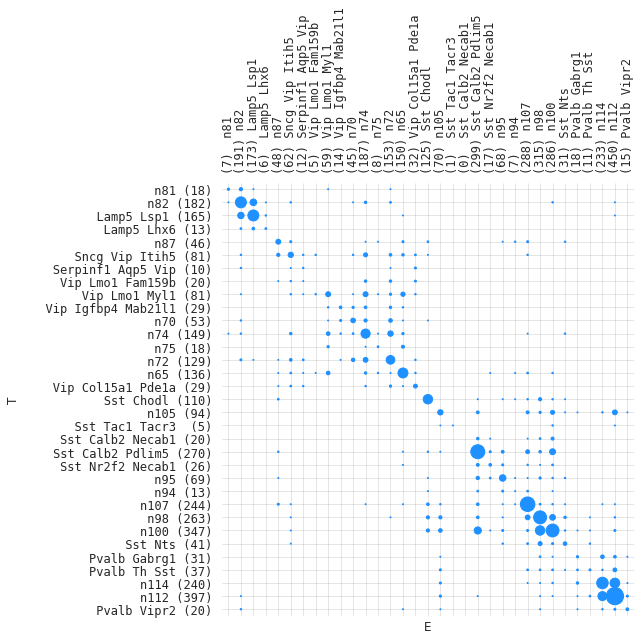

In [14]:
from refactor.utils.compute import CCA_extended
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

for fold in [0]:
    n_pc_T=20
    n_pc_E=20
    cca_dims=5
    
    cca = CCA(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)
    train_ind = ind_dict['train']
    test_ind = ind_dict['test']
    all_ind = np.concatenate([train_ind,test_ind]) 
    
    #Reduce dims of T data
    pcaT = PCA(n_components=n_pc_T)
    pcaT.fit_transform(XT[train_ind,:])
    XTpc = pcaT.transform(XT)

    #Reduce dims of E data
    pcaE = PCA(n_components=n_pc_E)
    pcaE.fit_transform(XE[train_ind,:])
    XEpc = pcaE.transform(XE)

    #CCA on T and E data
    cca.fit(XTpc[train_ind,:],XEpc[train_ind,:])
    XTcca,XEcca = cca.transform(XTpc,XEpc)
    
    qda.fit(XEcca[train_ind,:],gt_labels[train_ind])
    lbl_pred_E = qda.predict(XEcca)

    qda.fit(XTcca[train_ind,:],gt_labels[train_ind])
    lbl_pred_T = qda.predict(XTcca)

        
    xname = ref_tax_33_order.copy()
    xdata = [f'({np.sum(lbl_pred_E[all_ind]==n):d})' for n in ref_tax_33_order]
    xlabelc = [f'{b:<4s}'+ f' {a:s}' for (a,b) in zip(xname,xdata)]
    
    yname = ref_tax_33_order.copy()
    ydata = [f'({np.sum(lbl_pred_T[all_ind]==n):d})' for n in ref_tax_33_order]
    ylabelc = [f'{a:>20s} '+f'{b:>4s}' for (a,b) in zip(yname,ydata)]
    
    C_all = contingency(a=lbl_pred_T[all_ind],
                    b=lbl_pred_E[all_ind],
                    unique_a=ref_tax_33_order,
                    unique_b=ref_tax_33_order)
    
    C_test = contingency(a=lbl_pred_T[test_ind],
                b=lbl_pred_E[test_ind],
                unique_a=ref_tax_33_order,
                unique_b=ref_tax_33_order)
    
    C_T_gt_test_cca = contingency(a=lbl_pred_T[test_ind],
            b=gt_labels[test_ind],
            unique_a=ref_tax_33_order,
            unique_b=ref_tax_33_order)
    
    C_E_gt_test_cca = contingency(a=lbl_pred_E[test_ind],
        b=gt_labels[test_ind],
        unique_a=ref_tax_33_order,
        unique_b=ref_tax_33_order)
    
    _ = contingency_metric(C_all,verbose=True)
    matrix_scatterplot(C_all.copy(),
                       xticklabels=xlabelc,
                       yticklabels=ylabelc,
                       xlabel='E', ylabel='T',
                       mc = 'dodgerblue',
                       fig_width=9, 
                       fig_height=9, 
                       scale_factor=1.0)

    plt.show()

In [15]:
_ = contingency_metric(C_T_gt_test_cca)

Total samples: 677
Fraction of rows with strong diagonal: 0.848
Fraction of cols with strong diagonal: 0.818
Fraction of strong diagonals: 0.788
f_consistency: 0.790
f_occupancy: 0.909
f_confidence: 0.788
n(poor clusters): 7


In [16]:
_ = contingency_metric(C_E_gt_test_cca)

Total samples: 677
Fraction of rows with strong diagonal: 0.697
Fraction of cols with strong diagonal: 0.576
Fraction of strong diagonals: 0.576
f_consistency: 0.578
f_occupancy: 0.727
f_confidence: 0.576
n(poor clusters): 14


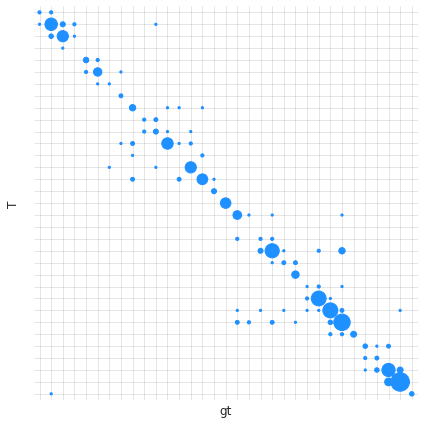

In [34]:
matrix_scatterplot(C_gt,
                   xticklabels=[],
                   yticklabels=[],
                   xlabel='gt', ylabel='T',
                   mc = 'dodgerblue',
                   fig_width=6, 
                   fig_height=6, 
                   scale_factor=5.0)

In [35]:
_ =contingency_metric(C_test)

Total samples: 677
Fraction of rows with strong diagonal: 0.545
Fraction of cols with strong diagonal: 0.667
Fraction of strong diagonals: 0.545
f_consistency: 0.564
f_occupancy: 0.758
f_confidence: 0.545
n(poor clusters): 15


In [ ]:
emp_P = np.sort(counts)/np.sum(counts)
uni_P = np.array([1/counts.size]*counts.size)
kl = np.sum(emp_P*np.log(emp_P/uni_P))
print(f'KL divergence wrt uniform distribution: {kl:0.3f}')

fname='/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/consensus_label_counts.mat'
consensus_label_counts = sio.loadmat(fname,squeeze_me=True)

plt.plot(np.sort(counts),'.-b',label='Reference Taxonomy 33')
plt.plot(np.sort(consensus_label_counts['consensus_label_counts']),'.-r',label='Consensus labels 33')
plt.legend()
ax = plt.gca()
ax.set_xlabel('Sorted cluster labels')
ax.set_xlabel('sample counts')
plt.show()

Index(['classes', ' avgacc', ' stdacc', ' avgfco', ' stdfco'], dtype='object')


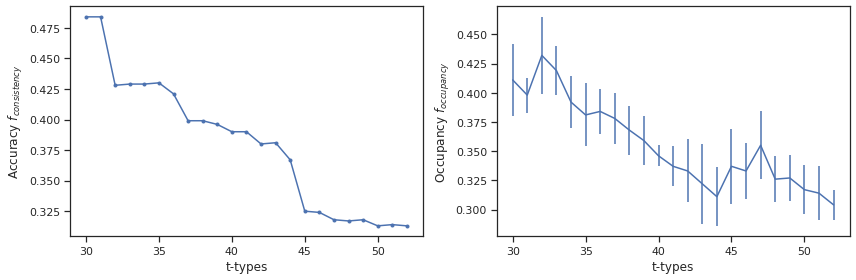

In [14]:
#Values for test set over different mergers 33-54
Dat=pd.read_csv('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/qda_uncoupled_representations.csv')
print(Dat.columns)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(Dat['classes'].values[25:],Dat[' avgacc'].values[25:],'.-')
ax = plt.gca()
ax.set_xlabel(r't-types')
ax.set_ylabel(r'Accuracy $f_{consistency}$')

plt.subplot(122)
plt.errorbar(Dat['classes'].values[25:],Dat[' avgfco'].values[25:], Dat[' stdfco'].values[25:])
ax = plt.gca()
ax.set_xlabel(r't-types')
ax.set_ylabel(r'Occupancy $f_{occupancy}$')
plt.tight_layout()
plt.show()